# Import and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import functions_simulation as sim
import fokkerplancksol as fpsol
snscolors=sns.color_palette() 

<module 'fokkerplancksol' from '/Users/user/Dropbox/Foraging as a decision problem/pythoncodes/paper_codes_for_github/fokkerplancksol.py'>

# Fig 1B:  Single patch simulation

rho0= 9.438579661861747
reached threshold


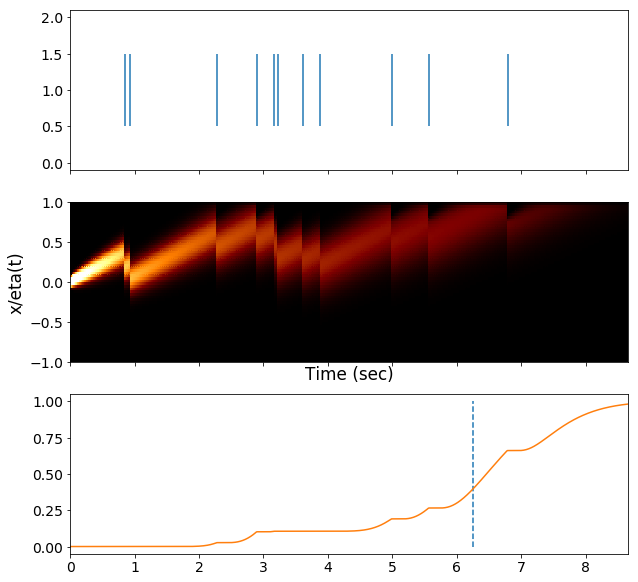

In [2]:
# Simulation parameters
dt=0.01  # remember that if use a finer mesh, need to use a smaller time step!
totaltime=50  # this is the maximum number of time steps, and also the amount of time for which that patch rewards are generated
numsteps=np.round(totaltime/dt).astype(int)

# Set environment, patch, and model parameters
Evalue = 2
tau_patch = 5
Ttravel=5
rho0=sim.getrho0_Eopt(Evalue,tau_patch,Ttravel)
print('rho0=',rho0) 
sigma=0.3*rho0
chunksize=4  # how big the chunk sizes are.  0 is continuous reward, larger values mean fewer, larger reward pieces
alpha=1*rho0  # example in the paper uses the density-adaptive strategy, i.e. alpha=1*rho0

# solve for threshold value, and generate rewards
eta = sim.eta_opt(Evalue,rho0,tau_patch,alpha)
etalist=np.ones(numsteps)*eta  # will use this to pass into FP solution... in this case, it is constant
allreward, _  = sim.generate_patch_rewards(chunksize,rho0,tau_patch,numsteps,dt=dt)

# Fokker Planck class:  initialize and get solution
numelements=51 # note!  needs to be an odd number
fp = fpsol.FPsolution(n=numelements) # initialize the class
allH, allG = fp.getsolution(allreward,etalist,alpha,sigma,dt,threshold=0.01)  # get solution

# some calculations for plotting
times=np.arange(numsteps)*dt
Texpected = np.sum(np.diff(1-allH)*times[1:])  # Expected patch residence time

## PLOT RESULTS
f,ax = plt.subplots(3,1,sharex=True)
f.set_size_inches(10,10)
lsize=14

ax[0].eventplot(times[allreward>0])
ax[0].set_xlim([0,times[allH<0.02][0]])
ax[0].tick_params(labelsize=lsize)

x=np.tile(times,(numelements,1)).T
y=np.tile(fp.mesh,(numsteps,1))
z=(allG[:,0:-1]+allG[:,1:])/2  # Plot the "element values", as the mean of the nodal values
ax[1].pcolormesh(x, y, z, cmap='afmhot',vmin=0,vmax=5,rasterized=True)
ax[1].set_xlabel('Time (sec)',fontsize=1.2*lsize)
ax[1].set_ylabel('x/eta(t)',fontsize=1.2*lsize)
ax[1].tick_params(labelsize=lsize)

ax[2].plot([Texpected,Texpected],[0,1],'--')
ax[2].plot(times,1-allH)
ax[2].tick_params(labelsize=lsize)
plt.show()

# Fig 1C:  Multiple patch simulation

rho0= 9.438579661861747
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold
reached threshold


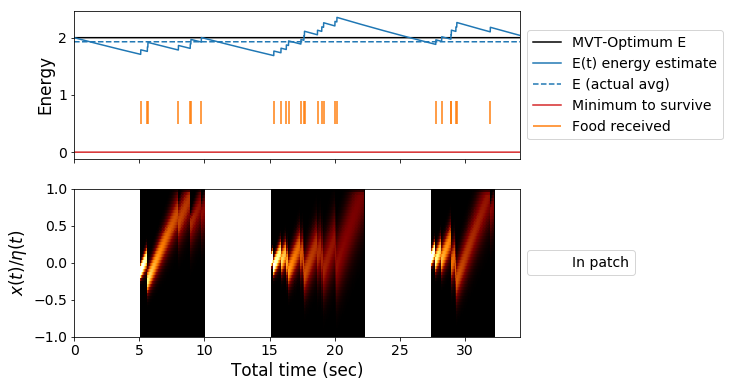

In [7]:

# Simulation parameters
dt=0.01  # remember that if use a finer mesh, need to use a smaller time step!
totaltime=150  # this is the maximum number of time steps, and also the amount of time for which that patch rewards are generated
numsteps=np.round(totaltime/dt).astype(int)

# Set environment, patch, and model parameters
Evalue = 2
tau_patch = 5
Ttravel=5
rho0=sim.getrho0_Eopt(Evalue,tau_patch,Ttravel)
print('rho0=',rho0) 
sigma=0.3*rho0
chunksize=4  # how big the chunk sizes are.  0 is continuous reward, larger values mean fewer, larger reward pieces
alpha=1*rho0  # example in the paper uses the density-adaptive strategy, i.e. alpha=1*rho0

sigma_rho0=0.0*rho0
sigma_taupatch=0.0*tau_patch
sigma_Ttravel=0
beta=0

# solve for threshold value, and generate rewards
eta = sim.eta_opt(Evalue,rho0,tau_patch,alpha)
etalist=np.ones(numsteps)*eta  # will use this to pass into FP solution... in this case, it is constant
allreward, _  = sim.generate_patch_rewards(chunksize,rho0,tau_patch,numsteps,dt=dt)

#  for convenience:
tau_E=sim.tau_E
s=sim.s
tau=sim.tau
# For calculating mean patch residence times and energy
start_for_mean=0
meanstep=np.round(start_for_mean/dt).astype(int)

# solve for optimal energy and optimal patch time
Eopt=sim.getEopt(rho0,tau_patch,Ttravel)
Topt=tau_patch*np.log(rho0/(Eopt+s))

maxmult=5 # how many times longer than Topt to consider for a simulation.  Should choose several times longer, to get a good solution
maxfpsteps=np.round(maxmult*Topt/dt).astype(int)

##### INITIALIZE THINGS
# Fokker Planck class:  initialize
numelements=51
fp = fpsol.FPsolution(n=numelements) # initialize the class

# variables for storing things, and their initial conditions
allE = np.zeros(numsteps)
allG = np.zeros((numsteps,numelements))
allEactual=np.zeros(numsteps)
patchsteps=[]
travelsteps=[]
rho0values=[]
taupatchvalues=[]


# initial conditions
allE[0] = 1.0*Eopt  # minimum in order to survive is s

# initialize for simulation
inpatch=False
rho0currentpatch = rho0 + sigma_rho0*np.random.randn()
Ttravel_current = np.max([ dt,Ttravel + sigma_Ttravel*np.random.randn()])  # minimum of 1 timestep to travel between patches
taupatch_current = tau_patch + sigma_taupatch*np.random.randn()
patch_startstep = 0
travel_startstep=0

alpha_current=rho0
u_current = (alpha_current)*np.exp(-beta*allE[0])  #for incorporating beta

##### Loop through time
rewardrate = rho0currentpatch
step=1
while (step<numsteps):
    if inpatch:
        # generate a list of rewards
        allreward, _  = sim.generate_patch_rewards(chunksize,rho0currentpatch,taupatch_current,maxfpsteps,dt=dt)
        # solve for E for the next steps, to make an input
        Epatch = np.zeros(maxfpsteps)
        Epatch_actual = allreward-s
        Epatch[0]=allE[step-1] +dt/tau_E*(allreward[0]-s-allE[step-1])
        for j in range(1,maxfpsteps):
            Epatch[j]=Epatch[j-1] +dt/tau_E*(allreward[j]-s-Epatch[j-1])
        
        alpha_current=rho0
        upatch=(alpha_current)*np.exp(-beta*Epatch)
        etalist = sim.eta_opt(Epatch,rho0,tau_patch,alpha)  # put in the 'global' rho0 and tau_patch values, because the agent doesn't actually know the patch-specific value of rho0 or tau_patch            
        
        Hpatch, Gpatch = fp.getsolution(allreward,etalist,upatch,sigma,dt,threshold=0.01)  # FP solution for this patch
        
        # get expectation time from FP solution
        times=np.arange(maxfpsteps)*dt
        Texpected = np.sum(np.diff(1-Hpatch)*times[1:])
        Tsteps = np.round(Texpected/dt).astype(int)
        
        step = step+Tsteps
        if step+1<numsteps:
            allG[patch_startstep:step+1] = Gpatch[0:Tsteps+1]
            allE[patch_startstep:step+1] = Epatch[0:Tsteps+1]
            allEactual[patch_startstep:step+1] = Epatch_actual[0:Tsteps+1]
        else:
            lentake=numsteps - patch_startstep
            allG[patch_startstep:step+1] = Gpatch[0:lentake]
            allE[patch_startstep:step+1] = Epatch[0:lentake]
            allEactual[patch_startstep:step+1] = Epatch_actual[0:lentake]            
        # now move out of the patch
        inpatch=False
        travel_startstep=step+1  # will start travel at the "next step"
        Ttravel_current = np.max([dt,Ttravel + sigma_Ttravel*np.random.randn()]) 
        patchsteps.append([patch_startstep,step])
        rho0values.append(rho0currentpatch)
        taupatchvalues.append(taupatch_current)      
        
    else:  # not in patch
        # iterate through and update energy
        # update E and x variables
        allE[step]=allE[step-1]+dt/tau_E*(-s-allE[step-1])
        allEactual[step]=-s
        # check if traveled long enough to reach a new patch
        if (step-travel_startstep)*dt>=Ttravel_current: # start being in a new patch
            inpatch=True
            patch_startstep=step+1  # because will start getting reward at the next step
            travelsteps.append([travel_startstep,step])
            rho0currentpatch = np.max([rho0 + sigma_rho0*np.random.randn(),0])
            taupatch_current = np.max([tau_patch + sigma_taupatch*np.random.randn(),0.1])
            rewardrate=rho0currentpatch
            alpha_current=rho0
            u_current=(alpha_current)*np.exp(-beta*allE[step-1])  
    # increment the step, either way
    step += 1
         
##### End of simulation loop.  Calculate some things and plot:  patch residence times, and actual distribution of travel times
def stepstotime(tl):
    temp=np.array(tl)
    return (temp[:,1]-temp[:,0])*dt

patchsteps=np.array(patchsteps)
steptoavg=[patchsteps[:,0][patchsteps[:,0]>meanstep][0],travelsteps[-1][1]]
patchkeep=(patchsteps[:,0]>=steptoavg[0]) & (patchsteps[:,1]<steptoavg[1]) 
meanEactual=np.mean(allEactual[steptoavg[0]:steptoavg[1]])  

#%%   PLOT
numpatches=3
lsize=14
plotrange=[0,(patchsteps[numpatches-1][1])*sim.dt+2]
numsteps=len(allE)
timevalues=np.arange(0,numsteps)*sim.dt
alleta = sim.eta_opt(allE,rho0,tau_patch,alpha)  # the time-dependent threshold used

f,ax=plt.subplots(2,1,sharex=True)
f.set_size_inches(10,6)
ax[0].plot(timevalues,np.ones(numsteps)*Evalue,label='MVT-Optimum E',color='k')
ax[0].plot(timevalues,allE,label='E(t) energy estimate',color=snscolors[0])
ax[0].plot(timevalues,meanEactual*np.ones(numsteps),'--',label='E (actual avg)',color=snscolors[0])
ax[0].set_ylabel('Energy',fontsize=1.2*lsize)
ax[0].set_xlim(plotrange)
ax[0].eventplot(timevalues[allEactual>0],color=snscolors[1],linelengths=0.4,lineoffsets=0.7,label="Food received")
ax[0].plot(timevalues,np.zeros(numsteps),label='Minimum to survive',color=snscolors[3])


x=np.tile(timevalues,(numelements,1)).T
y=np.tile(fp.mesh,(numsteps,1))
z=(allG[:,0:-1]+allG[:,1:])/2
for k in range(len(patchsteps)):
    if k==1:  # add a legend entry, but only do it once
        ax[1].axvspan((patchsteps[k][0])*sim.dt, patchsteps[k][1]*sim.dt, alpha=0, color='k',label='In patch')
    else:
        ax[1].axvspan((patchsteps[k][0]-1)*sim.dt, (patchsteps[k][1]-0)*sim.dt, alpha=0, color='k')        
ax[1].pcolormesh(x, y, z, cmap='afmhot',vmin=0,vmax=5,rasterized=True)
for k in range(len(travelsteps)):
        ax[1].axvspan((travelsteps[k][0])*sim.dt, travelsteps[k][1]*sim.dt, alpha=1, color='white')
ax[1].set_xlabel('Total time (sec)',fontsize=1.2*lsize)
ax[1].set_ylabel('$x(t)/\eta(t)$',fontsize=1.2*lsize)
ax[1].set_ylim([-1,1])

# create the legends for both
# Shrink current axis by 20%, then put legend tothe right
for ax in ax:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=lsize)
    ax.tick_params(labelsize=lsize)

# Fig 1D:  Patch rewards illustration

5000.0
5200.0


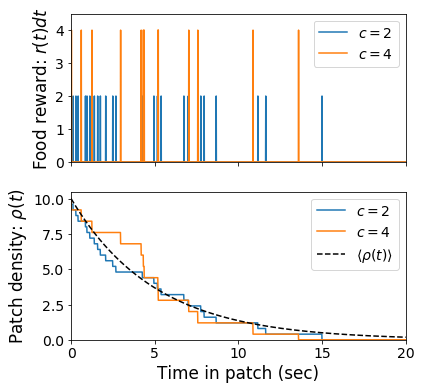

In [9]:
numsteps=2000
dt=0.01
rho0=10
tptimes=np.arange(numsteps)*dt
tau_patch=5

fig,ax=plt.subplots(2,1,sharex=True)
fig.set_size_inches((6,6))

for q in [2,4]:
    allreward, allrho = sim.generate_patch_rewards(q,rho0,tau_patch,numsteps,dt=dt)
    print(np.sum(allreward))
        
    ax[0].plot(tptimes,allreward*dt,label='$c=$'+str(q))    
    ax[1].plot(tptimes,allrho,label='$c=$'+str(q))

lsize=14
allreward0, allrho0 = sim.generate_patch_rewards(0,rho0,tau_patch,numsteps,dt=dt)
ax[1].plot(tptimes,allrho0,'k--',label="$\left<\\rho(t)\\right>$")
ax[1].set_xlabel('Time in patch (sec)',fontsize=1.2*lsize)
ax[0].set_ylabel('Food reward: $r(t) dt$',fontsize=1.2*lsize)
ax[1].set_ylabel('Patch density: $\\rho(t)$',fontsize=1.2*lsize)

ax[0].legend(fontsize=lsize)
ax[1].legend(fontsize=lsize)
ax[0].tick_params(labelsize=lsize)
ax[1].tick_params(labelsize=lsize)

ax[0].set_xlim([0,20])
ax[0].set_ylim([0,4.5])
ax[1].set_ylim([0,10.5])
plt.show()